In [1]:
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import pathlib

%cd "C:\Users\artemiyburov\prog\epidemic-datathon"

today = date.today()#todays date
pathlib.Path("plots\plots-total-cases\{}".format(today)).mkdir(parents=True, exist_ok=True)
pathlib.Path("plots\plots-total-recovered\{}".format(today)).mkdir(parents=True, exist_ok=True)
pathlib.Path("plots\plots-total-deaths\{}".format(today)).mkdir(parents=True, exist_ok=True)

c:\Users\artemiyburov\prog\epidemic-datathon


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/worldwide-aggregated.csv')
#df.plot(y='Confirmed', use_index = True)


x = df.index       #features
y = df['Confirmed']#labels
x_predicted = np.arange(150)

In [3]:
def logistic_function(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

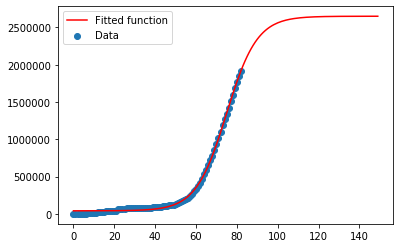

In [4]:

popt, pcov = curve_fit(logistic_function, x, y)
plt.scatter(x,y,label='Data')
plt.plot(x_predicted, logistic_function(x_predicted, *popt), 'r-',label='Fitted function')
plt.legend()


In [5]:
#create a valid filename from string
import unicodedata
import string

valid_filename_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
char_limit = 255

def clean_filename(filename, whitelist=valid_filename_chars, replace=' '):
    # replace spaces
    for r in replace:
        filename = filename.replace(r,'_')
    
    # keep only valid ascii chars
    cleaned_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode()
    
    # keep only whitelisted chars
    cleaned_filename = ''.join(c for c in cleaned_filename if c in whitelist)
    if len(cleaned_filename)>char_limit:
        print("Warning, filename truncated because it was over {}. Filenames may no longer be unique".format(char_limit))
    return cleaned_filename[:char_limit]

In [6]:
def plotter(*args):
    #plotting
    #plotting number
    if thickness>.1 and thickness<y_max and y_max<=y_predicted.max():
        #plot
        fig = plt.figure()
        plt.scatter(x,y,label='Data cases '+country)
        plt.plot(x_predicted, y_predicted, 'r-',label='Total cases fit '+country)
        plt.fill_between(x_predicted, y_predicted_inf, y_predicted_sup, color = 'black', alpha = 0.15)
        plt.legend()
        #save into a file
        fig.savefig("plots\plots-total-cases\{}\{}-total-cases-{}".format(today,clean_filename(country), today))
        plt.close()
    #plotting recovered
    if thicknessr>.1 and thicknessr<yr_max and yr_max<=yr_predicted.max():
        #plot
        fig = plt.figure()
        plt.scatter(x,yr,label='Data recovered '+country)
        plt.plot(x_predicted, yr_predicted, 'r-',label='Total recovered fit '+country)
        plt.fill_between(x_predicted, yr_predicted_inf, yr_predicted_sup, color = 'black', alpha = 0.15)
        plt.legend()
        #save into a file
        fig.savefig("plots\plots-total-recovered\{}\{}-total-recovered-{}".format(today,clean_filename(country), today))
        plt.close()
    #plotting deaths
    if thicknessd>.1 and thicknessd<yd_max and yd_max<=yd_predicted.max():
        #plot
        fig = plt.figure()
        plt.scatter(x,yd,label='Data deaths '+country)
        plt.plot(x_predicted, yd_predicted, 'r-',label='Total deaths fit '+country)
        plt.fill_between(x_predicted, yd_predicted_inf, yd_predicted_sup, color = 'black', alpha = 0.15)
        plt.legend()
        #save into a file
        fig.savefig("plots\plots-total-deaths\{}\{}-total-deaths-{}".format(today,clean_filename(country), today))
        plt.close()

In [7]:
df_by_country = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv')
#df.loc[df_by_country["Country"] == "South Africa"]
columns = ['Province/State','Country','Target/Date','N','low95N','high95N','R','low95R','high95R','D','low95D','high95D','T','low95T','high95T','M','low95M','high95M','C','low95C','high95C']
#df2day = pd.DataFrame(columns = columns)
plotted_status = False

#tomorrow = date.today()+timedelta(days=1)
#aftertomorrow = date.today()+timedelta(days=2)

prediction_lengths = [2,7,30]#choose the length of predicition here
for prediction_length in prediction_lengths:
    dfidays = pd.DataFrame(columns = columns)
    for country in df_by_country.Country.unique():
        df_country = df_by_country.loc[df_by_country["Country"] == country].reset_index()
        l = len(df_country)          #length of epidemic in a country
        x = df_country.index         #features
        y = df_country['Confirmed']  #labels
        yr = df_country['Recovered'] #labels recovered
        yd = df_country['Deaths']    #labels deaths
        y_max = y.max()
        y_norm = y/y_max
        yr_max = yr.max()
        yr_norm = yr/yr_max
        yd_max = yd.max()
        yd_norm = yd/yd_max
        x_predicted = np.arange(200)
        try:#number fit
            popt, pcov = curve_fit(logistic_function, x, y_norm)
        except:
            continue
        try:#recovered fit
            poptr, pcovr = curve_fit(logistic_function, x, y_norm)
        except:
            continue
        try:#deaths fit
            poptd, pcovd = curve_fit(logistic_function, x, y_norm)
        except:
            continue

        y_predicted = y_max*logistic_function(x_predicted, *popt)#confidence intervals cases
        sigma = np.sqrt(np.diagonal(pcov))#sqrt of covariance matrix
        y_predicted_sup = y_max*logistic_function(x_predicted, *(popt+2*sigma))#2 standard dev
        y_predicted_inf = y_max*logistic_function(x_predicted, *(popt-2*sigma))#2 standard dev
        thickness = max(abs(y_predicted_sup-y_predicted_inf))

        yr_predicted = yr_max*logistic_function(x_predicted, *poptr)#confidence intervals recovered
        sigma = np.sqrt(np.diagonal(pcovr))#sqrt of covariance matrix
        yr_predicted_sup = yr_max*logistic_function(x_predicted, *(poptr+2*sigma))#2 standard dev
        yr_predicted_inf = yr_max*logistic_function(x_predicted, *(poptr-2*sigma))#2 standard dev
        thicknessr = max(abs(yr_predicted_sup-yr_predicted_inf))

        yd_predicted = yd_max*logistic_function(x_predicted, *poptd)#confidence intervals deaths
        sigmad = np.sqrt(np.diagonal(pcovd))#sqrt of covariance matrix
        yd_predicted_sup = yd_max*logistic_function(x_predicted, *(poptd+2*sigma))#2 standard dev
        yd_predicted_inf = yd_max*logistic_function(x_predicted, *(poptd-2*sigma))#2 standard dev
        thicknessd = max(abs(yd_predicted_sup-yd_predicted_inf))
        
        if not plotted_status:
            plotter(x,y,yr,yd,x_predicted,y_predicted,yr_predicted,yd_predicted,y_predicted_inf,y_predicted_sup,yr_predicted_inf,yr_predicted_sup,yd_predicted_inf,yd_predicted_sup,thickness,thicknessr,thicknessd,y_max,yr_max,yd_max)

        #i day prediciton dataframe
        for i in np.arange(prediction_length):
            i = prediction_length-1
            dayi = date.today()+timedelta(days=int(i+1))
            N_dayi = y_predicted[l+i]#cases
            low95N_dayi = min(y_predicted_sup[l+i],y_predicted_inf[l+i])
            high95N_dayi = max(y_predicted_sup[l+i],y_predicted_inf[l+i])
            R_dayi = yr_predicted[l+i]#recovered
            low95R_dayi = min(yr_predicted_sup[l+i],yr_predicted_inf[l+i])
            high95R_dayi = max(yr_predicted_sup[l+i],yr_predicted_inf[l+i])
            D_dayi = yd_predicted[l+i]#deaths
            low95D_dayi = min(yd_predicted_sup[l+i],yd_predicted_inf[l+i])
            high95D_dayi = max(yd_predicted_sup[l+i],yd_predicted_inf[l+i])
            new_row_dayi = {'Province/State':'','Country':country, 'Target/Date':dayi, 'N':N_dayi,'low95N':low95N_dayi,'high95N':high95N_dayi, 'R':R_dayi, 'low95R':low95R_dayi,'high95R':high95R_dayi, 'D':D_dayi, 'low95D':low95D_dayi,'high95D':high95D_dayi,'T':'','low95T':'','high95T':'','M':'','low95M':'','high95M':'','C':'','low95C':'','high95C':''}
            dfidays.loc[len(dfidays)] = new_row_dayi
            break
    
    plotted_status = True
    dfidays.round(0).astype(int,copy = True,errors='ignore').to_csv("{}day_prediction_{}.csv".format(prediction_length,today+timedelta(days=0)),index=False)